# Clustering The World on COVID-19 Cases

This project attempts to cluster the world according to the pattern of COVID-19 cases in the past 28 days.

*Note - The graphs and results can be different each day, because the data at source is updated every day.*

Example - 5 clusters generated on 21st November 2020
![Clusters produced on 21st November 2020](countries-20201121.png)

## 1. Data Preparation

### Import Libraries

In [63]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import plotly.express as px
import plotly.io as pio

from datetime import date, datetime, timedelta

from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.preprocessing import StandardScaler

import joblib

pio.renderers.default = "plotly_mimetype+notebook_connected"

Set number of days for the study.

In [64]:
ndays = 28
dateformat = '%Y-%m-%d'
timestamp = datetime.now().strftime('%Y%m%d%H%M')

### Load Data

In [65]:
dataset_url = 'https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv'
df = pd.read_csv(dataset_url)
df

,Date,Country,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,0,0,0
1,2020-01-23,Afghanistan,0,0,0
2,2020-01-24,Afghanistan,0,0,0
3,2020-01-25,Afghanistan,0,0,0
4,2020-01-26,Afghanistan,0,0,0
...,...,...,...,...,...
58632,2020-11-19,Zimbabwe,9046,8195,265
58633,2020-11-20,Zimbabwe,9120,8229,265
58634,2020-11-21,Zimbabwe,9172,8235,265
58635,2020-11-22,Zimbabwe,9220,8250,268


### Data Wrangling

In [66]:
firstdate = df['Date'].min()
firstdate

'2020-01-22'

In [67]:
df = df.assign(Cases = np.where(df['Date'] == firstdate, df['Confirmed'], df['Confirmed'].diff()))
df['Cases'] = df['Cases'].astype(int)
df

,Date,Country,Confirmed,Recovered,Deaths,Cases
0,2020-01-22,Afghanistan,0,0,0,0
1,2020-01-23,Afghanistan,0,0,0,0
2,2020-01-24,Afghanistan,0,0,0,0
3,2020-01-25,Afghanistan,0,0,0,0
4,2020-01-26,Afghanistan,0,0,0,0
...,...,...,...,...,...,...
58632,2020-11-19,Zimbabwe,9046,8195,265,65
58633,2020-11-20,Zimbabwe,9120,8229,265,74
58634,2020-11-21,Zimbabwe,9172,8235,265,52
58635,2020-11-22,Zimbabwe,9220,8250,268,48


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58637 entries, 0 to 58636
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       58637 non-null  object
 1   Country    58637 non-null  object
 2   Confirmed  58637 non-null  int64 
 3   Recovered  58637 non-null  int64 
 4   Deaths     58637 non-null  int64 
 5   Cases      58637 non-null  int32 
dtypes: int32(1), int64(3), object(2)
memory usage: 2.5+ MB


### Calculate Dates

In [69]:
df['Date'] = pd.to_datetime(df['Date'], format = dateformat)
df.dtypes

Date         datetime64[ns]
Country              object
Confirmed             int64
Recovered             int64
Deaths                int64
Cases                 int32
dtype: object

In [70]:
df.drop(['Confirmed', 'Recovered', 'Deaths'], axis = 1, inplace = True)
df

,Date,Country,Cases
0,2020-01-22,Afghanistan,0
1,2020-01-23,Afghanistan,0
2,2020-01-24,Afghanistan,0
3,2020-01-25,Afghanistan,0
4,2020-01-26,Afghanistan,0
...,...,...,...
58632,2020-11-19,Zimbabwe,65
58633,2020-11-20,Zimbabwe,74
58634,2020-11-21,Zimbabwe,52
58635,2020-11-22,Zimbabwe,48


In [71]:
end = df['Date'].max()
end

Timestamp('2020-11-23 00:00:00')

In [72]:
start = end - timedelta(days = (ndays - 1))
start

Timestamp('2020-10-27 00:00:00')

### Create New Table

In [73]:
df_period = df[df['Date'] >= start]
df_period

,Date,Country,Cases
279,2020-10-27,Afghanistan,95
280,2020-10-28,Afghanistan,113
281,2020-10-29,Afghanistan,123
282,2020-10-30,Afghanistan,66
283,2020-10-31,Afghanistan,91
...,...,...,...
58632,2020-11-19,Zimbabwe,65
58633,2020-11-20,Zimbabwe,74
58634,2020-11-21,Zimbabwe,52
58635,2020-11-22,Zimbabwe,48


In [74]:
countries = df_period['Country'].unique()
countries

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Guin

In [75]:
df_grouped = df_period.groupby('Country')
df_grouped

In [76]:
sums = df_grouped['Cases'].sum()
sums

Country
Afghanistan            4051
Albania               14111
Algeria               19448
Andorra                1979
Angola                 4990
                      ...  
West Bank and Gaza    22244
Western Sahara            0
Yemen                    47
Zambia                 1254
Zimbabwe               1005
Name: Cases, Length: 191, dtype: int32

In [77]:
means = df_grouped['Cases'].mean()
means

Country
Afghanistan           144.678571
Albania               503.964286
Algeria               694.571429
Andorra                70.678571
Angola                178.214286
                         ...    
West Bank and Gaza    794.428571
Western Sahara          0.000000
Yemen                   1.678571
Zambia                 44.785714
Zimbabwe               35.892857
Name: Cases, Length: 191, dtype: float64

In [78]:
stds = df_grouped['Cases'].std()
stds

Country
Afghanistan            78.865593
Albania               170.368551
Algeria               284.642522
Andorra                41.193359
Angola                 69.189679
                         ...    
West Bank and Gaza    345.349681
Western Sahara          0.000000
Yemen                   2.228661
Zambia                 25.709714
Zimbabwe               22.844627
Name: Cases, Length: 191, dtype: float64

In [79]:
maxes = df_grouped['Cases'].max()
maxes

Country
Afghanistan            377
Albania                836
Algeria               1103
Andorra                184
Angola                 349
                      ... 
West Bank and Gaza    1552
Western Sahara           0
Yemen                    8
Zambia                 118
Zimbabwe                88
Name: Cases, Length: 191, dtype: int32

In [80]:
mins = df_grouped['Cases'].min()
mins

Country
Afghanistan            40
Albania               241
Algeria               287
Andorra                 0
Angola                 77
                     ... 
West Bank and Gaza    420
Western Sahara          0
Yemen                   0
Zambia                  4
Zimbabwe                5
Name: Cases, Length: 191, dtype: int32

In [81]:
medians = df_grouped['Cases'].median()
medians

Country
Afghanistan           127.5
Albania               498.0
Algeria               711.5
Andorra                64.5
Angola                169.5
                      ...  
West Bank and Gaza    666.5
Western Sahara          0.0
Yemen                   1.0
Zambia                 39.5
Zimbabwe               29.5
Name: Cases, Length: 191, dtype: float64

In [82]:
df_countries = pd.DataFrame(
    {
        'Country': countries,
        'Sum': sums,
        'Mean': means,
        'Std': stds,
        'Max': maxes,
        'Min': mins,
        'Median': medians
    }
)

df_countries

,Country,Sum,Mean,Std,Max,Min,Median
Country,,,,,,,
Afghanistan,Afghanistan,4051,144.678571,78.865593,377,40,127.5
Albania,Albania,14111,503.964286,170.368551,836,241,498.0
Algeria,Algeria,19448,694.571429,284.642522,1103,287,711.5
Andorra,Andorra,1979,70.678571,41.193359,184,0,64.5
Angola,Angola,4990,178.214286,69.189679,349,77,169.5
...,...,...,...,...,...,...,...
West Bank and Gaza,West Bank and Gaza,22244,794.428571,345.349681,1552,420,666.5
Western Sahara,Western Sahara,0,0.000000,0.000000,0,0,0.0
Yemen,Yemen,47,1.678571,2.228661,8,0,1.0


In [83]:
df_countries.reset_index(drop = True, inplace = True)
df_countries

,Country,Sum,Mean,Std,Max,Min,Median
0,Afghanistan,4051,144.678571,78.865593,377,40,127.5
1,Albania,14111,503.964286,170.368551,836,241,498.0
2,Algeria,19448,694.571429,284.642522,1103,287,711.5
3,Andorra,1979,70.678571,41.193359,184,0,64.5
4,Angola,4990,178.214286,69.189679,349,77,169.5
...,...,...,...,...,...,...,...
186,West Bank and Gaza,22244,794.428571,345.349681,1552,420,666.5
187,Western Sahara,0,0.000000,0.000000,0,0,0.0
188,Yemen,47,1.678571,2.228661,8,0,1.0
189,Zambia,1254,44.785714,25.709714,118,4,39.5


### Explore Data

In [84]:
df_countries.isnull().sum()

Country    0
Sum        0
Mean       0
Std        0
Max        0
Min        0
Median     0
dtype: int64

In [85]:
df_countries[df_countries['Country'] == 'US']

,Country,Sum,Mean,Std,Max,Min,Median
176,US,3715141,132683.607143,36548.327952,196004,75559,130622.0


In [86]:
df_countries[df_countries['Country'] == 'India']

,Country,Sum,Mean,Std,Max,Min,Median
79,India,1231411,43978.964286,5304.519516,50356,29163,45403.5


In [87]:
df_countries[df_countries['Country'] == 'Malaysia']

,Country,Sum,Mean,Std,Max,Min,Median
107,Malaysia,28854,1030.5,287.236707,1884,649,990.5


## 2. Data Visualization

In [88]:
fig = px.choropleth(df_countries, locations = 'Country', locationmode = 'country names', color = 'Sum')
fig.update_layout(title_text = f'COVID-19 - Total Number of Cases in Past {ndays} Days', title_x = 0.5)
fig.show()

In [89]:
fig = px.choropleth(df_countries, locations = 'Country', locationmode = 'country names', color = 'Mean')
fig.update_layout(title_text = f'COVID-19 - Daily Average Number of Cases in Past {ndays} Days', title_x = 0.5)
fig.show()

In [90]:
fig = px.choropleth(df_countries, locations = 'Country', locationmode = 'country names', color = 'Std')
fig.update_layout(title_text = f'COVID-19 - Standard Deviation of Number of Daily Cases in Past {ndays} Days', title_x = 0.5)
fig.show()

In [91]:
fig = px.choropleth(df_countries, locations = 'Country', locationmode = 'country names', color = 'Max')
fig.update_layout(title_text = f'COVID-19 - Highest Number of Daily Cases in Past {ndays} Days', title_x = 0.5)
fig.show()

In [92]:
fig = px.choropleth(df_countries, locations = 'Country', locationmode = 'country names', color = 'Min')
fig.update_layout(title_text = f'COVID-19 - Lowest Number of Daily Cases in Past {ndays} Days', title_x = 0.5)
fig.show()

In [93]:
fig = px.choropleth(df_countries, locations = 'Country', locationmode = 'country names', color = 'Median')
fig.update_layout(title_text = f'COVID-19 - Median Number of Daily Cases in Past {ndays} Days', title_x = 0.5)
fig.show()

In [94]:
df_countries.corr()

,Sum,Mean,Std,Max,Min,Median
Sum,1.000000,1.000000,0.898146,0.945975,0.945779,0.999657
Mean,1.000000,1.000000,0.898146,0.945975,0.945779,0.999657
Std,0.898146,0.898146,1.000000,0.982032,0.717297,0.894016
Max,0.945975,0.945975,0.982032,1.000000,0.800785,0.943187
Min,0.945779,0.945779,0.717297,0.800785,1.000000,0.947524
Median,0.999657,0.999657,0.894016,0.943187,0.947524,1.000000


## Model Training

In [95]:
# Features = df_countries.drop(['Country', 'Sum'], axis = 1).columns # Use almost all columns for training
Features = ['Median', 'Std'] # Use selected columns for training
Features

['Median', 'Std']

In [96]:
scaled_features = StandardScaler().fit_transform(df_countries[Features])

In [97]:
start = 2
end = 11

sse = []

kmeans_kwargs = {
   "init": "random",
   "n_init": 10,
   "max_iter": 300,
   "random_state": 42,
}

for k in range(start, end):
    print(f'Trying {k} clusters...')
    
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)
    print(f'SSE: {kmeans.inertia_}')
    
    print()

Trying 2 clusters...
SSE: 160.22421901213457

Trying 3 clusters...
SSE: 78.75290341978506

Trying 4 clusters...
SSE: 33.50939461633718

Trying 5 clusters...
SSE: 18.031963051789656

Trying 6 clusters...
SSE: 15.457892527317979

Trying 7 clusters...
SSE: 13.794148162209783

Trying 8 clusters...
SSE: 13.237928261010385

Trying 9 clusters...
SSE: 13.079167432710868

Trying 10 clusters...
SSE: 13.058170042238169



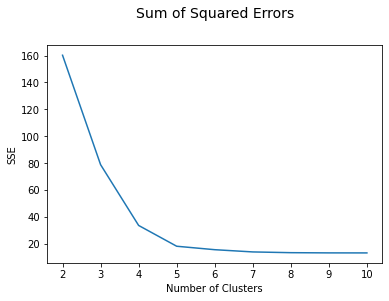

In [98]:
plt.plot(range(start, end), sse)
plt.xticks(range(start, end))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title('Sum of Squared Errors', y = 1.1, fontsize = 14)
plt.show()

In [99]:
kl = KneeLocator(
   range(start, end), sse, curve="convex", direction="decreasing"
)

print(f'The optimal number of clusters: {kl.elbow}')

The optimal number of clusters: 4


In [100]:
kclusters = kl.elbow

kmeans = KMeans(n_clusters = kclusters, **kmeans_kwargs)
kmeans.fit(scaled_features)

labels = kmeans.labels_ + 1
labels

array([1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1,
       1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 3, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       4, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### Explore Clusters

In [101]:
if 'Cluster' in df_countries.columns:
    df_countries.drop('Cluster', axis = 1, inplace = True)
    
df_countries.insert(0, 'Cluster', labels)
df_countries

,Cluster,Country,Sum,Mean,Std,Max,Min,Median
0,1,Afghanistan,4051,144.678571,78.865593,377,40,127.5
1,1,Albania,14111,503.964286,170.368551,836,241,498.0
2,1,Algeria,19448,694.571429,284.642522,1103,287,711.5
3,1,Andorra,1979,70.678571,41.193359,184,0,64.5
4,1,Angola,4990,178.214286,69.189679,349,77,169.5
...,...,...,...,...,...,...,...,...
186,1,West Bank and Gaza,22244,794.428571,345.349681,1552,420,666.5
187,1,Western Sahara,0,0.000000,0.000000,0,0,0.0
188,1,Yemen,47,1.678571,2.228661,8,0,1.0
189,1,Zambia,1254,44.785714,25.709714,118,4,39.5


In [102]:
df_plot = pd.DataFrame(df_countries['Cluster'].value_counts(sort = False))
df_plot.index.name = 'Cluster'
df_plot.columns = ['Count']
df_plot

,Count
Cluster,
1,171
2,5
3,14
4,1


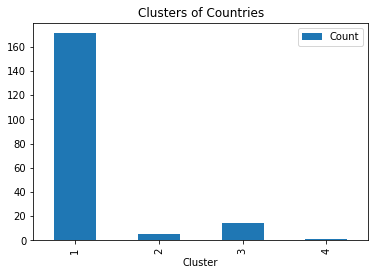

In [103]:
df_plot.plot.bar(title = 'Clusters of Countries')

Learn the characteristics of each cluster.

In [104]:
df_clusters = df_countries.groupby('Cluster')
df_clusters

In [105]:
for i in range(1, kclusters + 1):
    print(df_clusters.get_group(i))

     Cluster             Country    Sum        Mean         Std   Max  Min  \
0          1         Afghanistan   4051  144.678571   78.865593   377   40   
1          1             Albania  14111  503.964286  170.368551   836  241   
2          1             Algeria  19448  694.571429  284.642522  1103  287   
3          1             Andorra   1979   70.678571   41.193359   184    0   
4          1              Angola   4990  178.214286   69.189679   349   77   
..       ...                 ...    ...         ...         ...   ...  ...   
186        1  West Bank and Gaza  22244  794.428571  345.349681  1552  420   
187        1      Western Sahara      0    0.000000    0.000000     0    0   
188        1               Yemen     47    1.678571    2.228661     8    0   
189        1              Zambia   1254   44.785714   25.709714   118    4   
190        1            Zimbabwe   1005   35.892857   22.844627    88    5   

     Median  
0     127.5  
1     498.0  
2     711.5  
3      

In [106]:
df_clusters['Sum'].mean()

Cluster
1    1.843264e+04
2    8.537512e+05
3    3.241573e+05
4    3.715141e+06
Name: Sum, dtype: float64

In [107]:
df_clusters['Mean'].mean()

Cluster
1       658.308688
2     30491.114286
3     11577.045918
4    132683.607143
Name: Mean, dtype: float64

In [108]:
df_clusters['Std'].mean()

Cluster
1      223.900416
2    12287.389322
3     3579.459427
4    36548.327952
Name: Std, dtype: float64

In [109]:
df_clusters['Max'].mean()

Cluster
1      1159.444444
2     64069.200000
3     19310.071429
4    196004.000000
Name: Max, dtype: float64

In [110]:
df_clusters['Min'].mean()

Cluster
1      281.929825
2    10241.800000
3     5920.000000
4    75559.000000
Name: Min, dtype: float64

In [111]:
df_clusters['Median'].mean()

Cluster
1       650.628655
2     30865.100000
3     11302.071429
4    130622.000000
Name: Median, dtype: float64

### Visualize Clusters

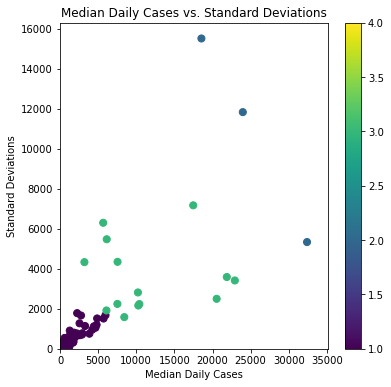

In [112]:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111)

scatter = ax.scatter(df_countries['Median'], df_countries['Std'], c = df_countries['Cluster'], s = 50)

ax.set_title('Median Daily Cases vs. Standard Deviations')
ax.set_xlabel('Median Daily Cases')
ax.set_ylabel('Standard Deviations')
ax.set_xlim(0, df_countries['Median'].quantile(0.99))
ax.set_ylim(0, df_countries['Std'].quantile(0.99))

plt.colorbar(scatter)

In [113]:
fig_countries = px.choropleth(df_countries, locations = 'Country', locationmode = 'country names', color = df_countries['Cluster'])
fig_countries.update_layout(title_text = f'Clustering The World into {kclusters} Clusters based on COVID-19 Cases in Past {ndays} Days', title_x = 0.5)
fig_countries.update_coloraxes(showscale = False)
fig_countries.show()

### Save Figure, Data and Model

In [115]:
# fig_countries.write_image('countries-' + timestamp + '.png')

In [ ]:
df_countries.to_csv('countries-' + timestamp + '.csv', index = False)

In [ ]:
joblib.dump(kmeans, 'model-' + timestamp + '.pkl')